In [5]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import csv

### Data Loader

In [6]:
csv_file_path = '../parsed_data.csv'
parsed_data = []
parsed_signal_data = []
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_data.append(data_point)

print(len(parsed_data))

with open("../parsed_signal_data.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_signal_data.append(data_point)

print(len(parsed_signal_data))

350181
53000


#### Pt Normalization

In [7]:
for arr in parsed_data:
    for i in range(len(arr)):
        if i % 3 ==0:
            arr[i] = arr[i] /100.0
print("done with background")
for arr in parsed_signal_data:
    for i in range(len(arr)):
        if i % 3 ==0:
            arr[i] = arr[i] /100.0

done with background


### First Round of Adjustment

Idea is to add more nodes and more layers to increase complexity, lose some genearlization but gain a lot more accuracy. To counteract overfitting, we will increase batch size to help.

In [9]:
# class AutoEncoder(torch.nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()
#         self.encoder = torch.nn.Sequential(
#             torch.nn.Linear(12, 6),
#             torch.nn.ReLU(),
#             torch.nn.Linear(6, 12),
#             torch.nn.ReLU(),
#             torch.nn.Linear(12, 9),
#             torch.nn.ReLU(),
#             torch.nn.Linear(9, 3),
#         )
#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(3, 9),
#             torch.nn.ReLU(),          # gonna try sigmoid here as well
#             torch.nn.Linear(9, 12),
#             torch.nn.ReLU(),
#             torch.nn.Linear(12, 6),  
#             torch.nn.ReLU(),
#             torch.nn.Linear(6, 12),
#             torch.nn.ReLU(),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(18, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 3),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 9),
            torch.nn.ReLU(),          # gonna try sigmoid here as well
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 6),  
            torch.nn.ReLU(),
            torch.nn.Linear(6, 18),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')


GPU is available


In [22]:
from sklearn.model_selection import train_test_split

tensor_data = torch.tensor(parsed_data, dtype=torch.float)
train_data, val_data = train_test_split(tensor_data, test_size=0.2, random_state=42)
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
batch_size = 128  # adjust later
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
model = AutoEncoder()
model.to(device)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 


In [23]:
num_epochs = 30  # Number of training epochs
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for data in train_dataloader:
        inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    train_loss /= len(train_dataloader.dataset)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradients for validation
        for data in val_dataloader:
            inputs = data[0].to(device)  # Assuming data is a tuple of (input, target)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            val_loss += loss.item() * inputs.size(0)

    # Calculate average validation loss
    val_loss /= len(val_dataloader.dataset)

    # Print epoch summary
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/30, Training Loss: 3.3679, Validation Loss: 1.7900
Epoch 2/30, Training Loss: 1.7441, Validation Loss: 1.7060
Epoch 3/30, Training Loss: 1.6515, Validation Loss: 1.5858
Epoch 4/30, Training Loss: 1.5611, Validation Loss: 1.5544
Epoch 5/30, Training Loss: 1.5491, Validation Loss: 1.5495
Epoch 6/30, Training Loss: 1.5463, Validation Loss: 1.5469
Epoch 7/30, Training Loss: 1.5443, Validation Loss: 1.5447
Epoch 8/30, Training Loss: 1.5428, Validation Loss: 1.5440
Epoch 9/30, Training Loss: 1.5418, Validation Loss: 1.5433
Epoch 10/30, Training Loss: 1.5413, Validation Loss: 1.5430
Epoch 11/30, Training Loss: 1.5407, Validation Loss: 1.5434
Epoch 12/30, Training Loss: 1.5403, Validation Loss: 1.5422
Epoch 13/30, Training Loss: 1.5399, Validation Loss: 1.5416
Epoch 14/30, Training Loss: 1.5398, Validation Loss: 1.5411
Epoch 15/30, Training Loss: 1.5396, Validation Loss: 1.5424
Epoch 16/30, Training Loss: 1.5397, Validation Loss: 1.5425
Epoch 17/30, Training Loss: 1.5395, Validation Lo

In [21]:
model_save_path = "autoencoder_model_3.pth"
torch.save(model.state_dict(), model_save_path)

## Model Evaluation through Background Reconstruction Error & Signal Reconstruction Error

Iteration 1

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

background_tensor_data = torch.tensor(parsed_data, dtype=torch.float)
background_dataset = TensorDataset(background_tensor_data)
background_dataloader = DataLoader(background_dataset, batch_size=8192, shuffle=False)

background_reconstruction_loss = []
model = AutoEncoder()  # Replace with your actual model class name
model.load_state_dict(torch.load('../model/autoencoder_model_3.pth', map_location=device))
model.to(device)
model.eval()
with torch.no_grad():
    for data in background_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        background_reconstruction_loss.extend(error.cpu().numpy())

GPU is available


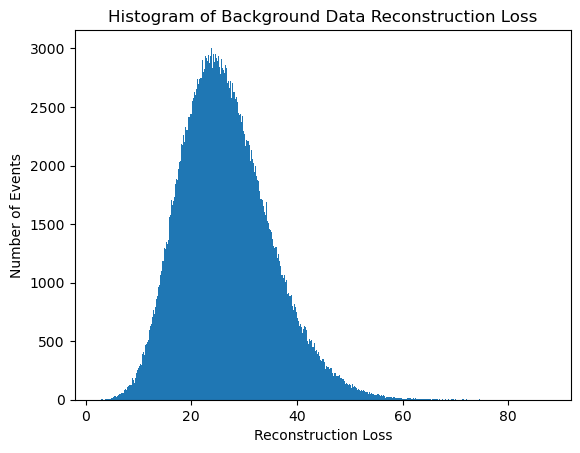

In [11]:
plt.hist(background_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Background Data Reconstruction Loss")
plt.show()

In [12]:
max_error = max(background_reconstruction_loss)
min_error = min(background_reconstruction_loss)
print(max_error)
print(min_error)

87.57663
2.233406


In [13]:
sum = 0
for i in background_reconstruction_loss:
    sum += i

print(sum/len(background_reconstruction_loss))

26.629272976324035


#### Signal Reconstruction Error

In [14]:
signal_tensor_data = torch.tensor(parsed_signal_data, dtype=torch.float)
signal_dataset = TensorDataset(signal_tensor_data)
signal_dataloader = DataLoader(signal_dataset, batch_size=8192, shuffle=False)

signal_reconstruction_loss = []
with torch.no_grad():
    for data in signal_dataloader:
        inputs = data[0].to(device)
        reconstructed = model(inputs)
        error = torch.sum((inputs-reconstructed)**2, dim=1)
        signal_reconstruction_loss.extend(error.cpu().numpy())

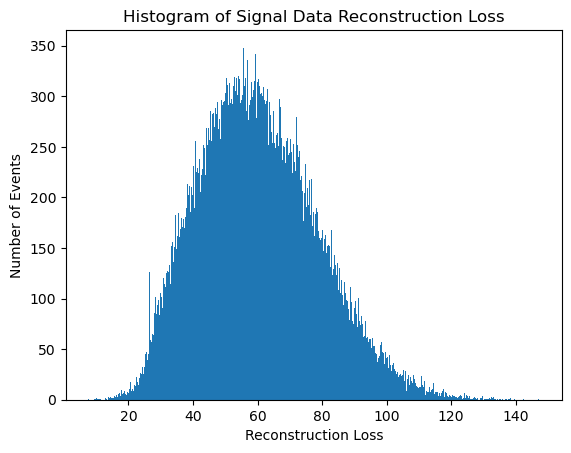

In [15]:
plt.hist(signal_reconstruction_loss, bins=500)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events')
plt.title("Histogram of Signal Data Reconstruction Loss")
plt.show()

In [16]:
max_error = max(signal_reconstruction_loss)
min_error = min(signal_reconstruction_loss)
print(max_error)
print(min_error)

147.31259
7.595403


In [17]:
sum = 0
for i in signal_reconstruction_loss:
    sum += i

print(sum/len(signal_reconstruction_loss))

60.25954480643542


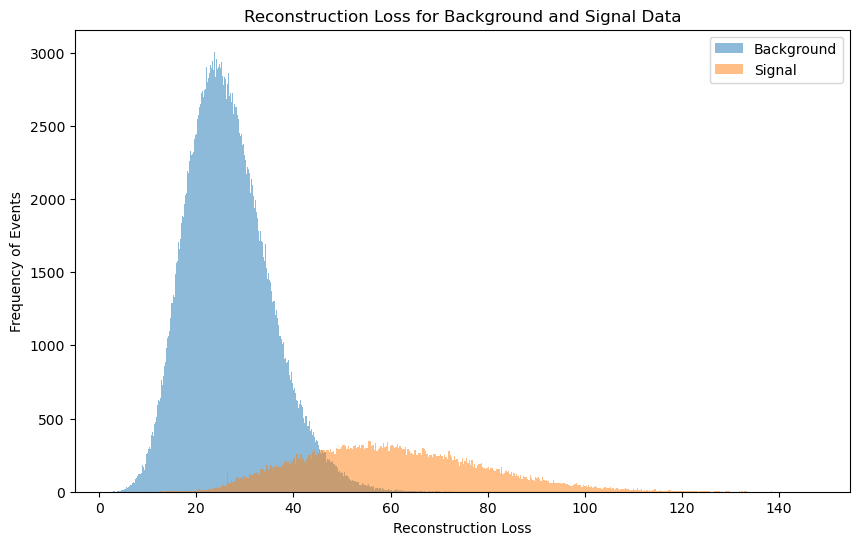

In [18]:
plt.figure(figsize=(10,6))

plt.hist(background_reconstruction_loss, bins=500, alpha=0.5, label='Background')
plt.hist(signal_reconstruction_loss, bins=500, alpha=0.5, label='Signal')   

plt.title("Reconstruction Loss for Background and Signal Data")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency of Events")
plt.legend(loc='upper right')

plt.show()

In [20]:
new_signal_reconstruction_loss = []
for x,signal in enumerate(0, signal_reconstruction_loss):
    if x % 10 ==0:
        new_signal_reconstruction_loss.append(signal)


plt.figure(figsize=(10,6))

plt.hist(background_reconstruction_loss, bins=500, alpha=0.5, label='Background')
plt.hist(new_signal_reconstruction_loss, bins=500, alpha=0.5, label='Signal')   

plt.title("Reconstruction Loss for Background and Signal Data")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency of Events")
plt.legend(loc='upper right')

plt.show()   

TypeError: 'list' object cannot be interpreted as an integer

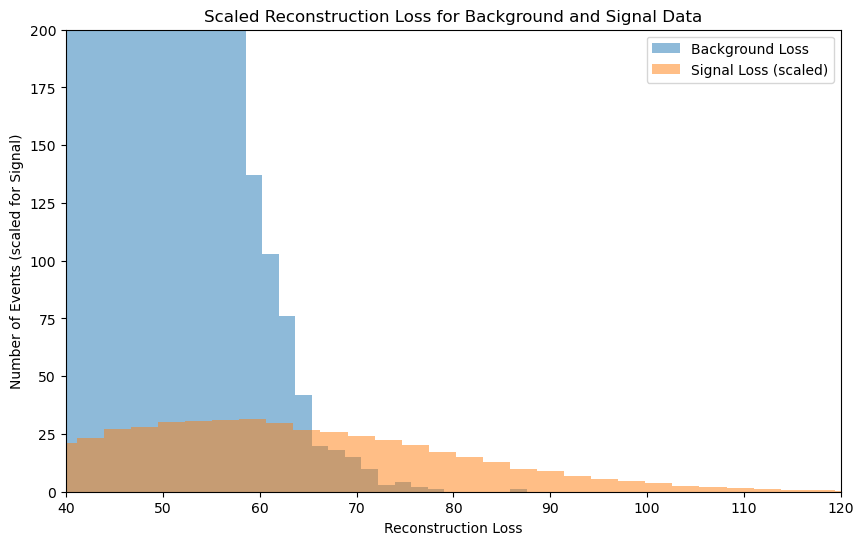

In [27]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming 'background_loss' and 'signal_loss' are arrays or lists containing the loss values

plt.figure(figsize=(10, 6))

# Calculate weights for signal to reflect their relative rarity
signal_weights = np.ones_like(signal_reconstruction_loss) / 100

# Plot histograms
plt.hist(background_reconstruction_loss, bins=50, alpha=0.5, label='Background Loss', density=False)
plt.hist(signal_reconstruction_loss, bins=50, weights=signal_weights, alpha=0.5, label='Signal Loss (scaled)', density=False)

# Adding titles and labels
plt.title('Scaled Reconstruction Loss for Background and Signal Data')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Number of Events (scaled for Signal)')
plt.legend(loc='upper right')
plt.xlim(40, 120)
plt.ylim(0,200)
# Show the plot
plt.show()